# Experiment: Deep RL vs MVO Portfolio Allocation Reproduction

このノートブックは論文 *Deep Reinforcement Learning for Optimal Portfolio Allocation: A Comparative Study with Mean-Variance Optimization* の Phase B 再現実装用です。


## 0. 実装方針（Phase B）

- 1論文 = 1ノートブックの原則で実装する。
- 比較対象は DRL（PPO, Differential Sharpe Reward）と MVO（Sharpe 最大化, Ledoit-Wolf）。
- 時系列リークを防ぐため、特徴量は時点 `t` まで、報酬は `t->t+1` で整合。
- 論文既定値（`n_envs=10`, `total_timesteps=7.5M` など）はデフォルトで保持し、重い処理はフラグで実行可否を制御する。


In [51]:
from __future__ import annotations

import json
import math
import random
import warnings
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import Callable, Dict, List, Optional, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from gymnasium import spaces
from pypfopt import EfficientFrontier
from sklearn.covariance import LedoitWolf
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

pd.options.display.float_format = "{:,.6f}".format
print("Imports ready")


Imports ready


In [52]:
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "docs").exists():
    PROJECT_ROOT = Path(
        "/Users/kencharoff/workspace/projects/rl/p01_deep_reinforcement_learning_for_optimal_portfolio_allocation"
    )


@dataclass
class ExperimentConfig:
    start_date: str = "2005-10-01"  # 60営業日前処理を含む余裕期間
    end_date: str = "2025-12-31"

    # ローカルCSV入力
    data_dir: str = "data"
    sector_returns_csv: str = "data/sector_returns.csv"
    macro_csv: str = "data/macro.csv"
    spx_csv: str = "data/SPX.csv"

    lookback: int = 60
    initial_cash: float = 100_000.0

    # 論文条件（PPO）
    total_timesteps: int = 1024 * 4 #7_500_000
    n_envs: int = 10
    n_steps: int = 756
    batch_size: int = 1260
    n_epochs: int = 16
    gamma: float = 0.9
    gae_lambda: float = 0.9
    clip_range: float = 0.25
    learning_rate_start: float = 3e-4
    learning_rate_end: float = 1e-5
    policy_hidden_sizes: Tuple[int, int] = (64, 64)
    log_std_init: float = -1.0
    eta: float = 1 / 252

    seeds: Tuple[int, ...] = (11, 22, 33, 44, 55)

    # 実行制御
    run_full_training: bool = True
    run_backtest_only: bool = False
    use_progress_bar: bool = False
    device: str = "auto"

NOTEBOOK_PATH = PROJECT_ROOT / "notebooks" / "deep_rl_vs_mvo_portfolio_allocation_reproduction.ipynb"
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "phase_b"
ARTIFACT_DIR = OUTPUT_DIR / "artifacts"
MODEL_DIR = ARTIFACT_DIR / "models"

for d in [OUTPUT_DIR, ARTIFACT_DIR, MODEL_DIR]:
    d.mkdir(parents=True, exist_ok=True)

cfg = ExperimentConfig()
print("PROJECT_ROOT:", PROJECT_ROOT)
print("OUTPUT_DIR:", OUTPUT_DIR)
print("Config loaded")


PROJECT_ROOT: /Users/kencharoff/workspace/projects/rl/p01_deep_reinforcement_learning_for_optimal_portfolio_allocation
OUTPUT_DIR: /Users/kencharoff/workspace/projects/rl/p01_deep_reinforcement_learning_for_optimal_portfolio_allocation/outputs/phase_b
Config loaded


## 1. データ取得・整形

- 入力: `data/sector_returns.csv`, `data/macro.csv`, `data/SPX.csv`
- `sector_returns.csv` の日次リターンから価格系列を再構成し、`asset_simple_ret` / `asset_logret` を作成。
- マクロ特徴量は `^VIX`, `DX-Y.NYB`, `SPRED` を expanding z-score 化して `vix_z`, `dxy_z`, `spred_z` として利用。
- 特徴量標準化は expanding window を使い、未来情報リークを防止。


In [53]:
def _resolve_path(path_str: str) -> Path:
    p = Path(path_str)
    if p.is_absolute():
        return p
    return PROJECT_ROOT / p


def _read_csv_with_date_index(path: Path, label: str) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"{label} not found: {path}")

    df = pd.read_csv(path)
    if "Date" not in df.columns:
        raise ValueError(f"{label} must include 'Date' column: {path}")

    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    if df["Date"].isna().any():
        raise ValueError(f"{label} has invalid Date values: {path}")

    df = df.sort_values("Date").drop_duplicates(subset=["Date"], keep="last")
    df = df.set_index("Date")
    return df


def _validate_columns(df: pd.DataFrame, required: List[str], label: str):
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"{label} missing columns: {missing}")


def _expanding_zscore(series: pd.Series, min_periods: int = 60) -> pd.Series:
    mu = series.expanding(min_periods=min_periods).mean()
    sigma = series.expanding(min_periods=min_periods).std(ddof=0)
    z = (series - mu) / sigma.replace(0.0, np.nan)
    return z


def load_dataset(config: ExperimentConfig) -> Dict[str, pd.DataFrame]:
    sector_path = _resolve_path(config.sector_returns_csv)
    macro_path = _resolve_path(config.macro_csv)
    spx_path = _resolve_path(config.spx_csv)

    sector_df = _read_csv_with_date_index(sector_path, "sector_returns.csv")
    macro_df = _read_csv_with_date_index(macro_path, "macro.csv")
    spx_df = _read_csv_with_date_index(spx_path, "SPX.csv")

    _validate_columns(macro_df, ["^VIX", "DX-Y.NYB", "SPRED"], "macro.csv")
    _validate_columns(spx_df, ["^GSPC"], "SPX.csv")

    sector_cols = [c for c in sector_df.columns if c != "Date"]
    if len(sector_cols) == 0:
        raise ValueError("sector_returns.csv must include at least one asset return column")

    start_ts = pd.Timestamp(config.start_date)
    end_ts = pd.Timestamp(config.end_date)

    sector_df = sector_df[(sector_df.index >= start_ts) & (sector_df.index <= end_ts)]
    macro_df = macro_df[(macro_df.index >= start_ts) & (macro_df.index <= end_ts)]
    spx_df = spx_df[(spx_df.index >= start_ts) & (spx_df.index <= end_ts)]

    idx = sector_df.index.intersection(macro_df.index).intersection(spx_df.index)
    if len(idx) == 0:
        raise ValueError("No intersecting dates among sector_returns.csv, macro.csv, SPX.csv")

    asset_simple_ret = sector_df.loc[idx, sector_cols].astype(float).sort_index()
    macro_raw = macro_df.loc[idx, ["^VIX", "DX-Y.NYB", "SPRED"]].astype(float).sort_index()
    market = spx_df.loc[idx, ["^GSPC"]].astype(float).rename(columns={"^GSPC": "SPX"}).sort_index()
    vix = macro_df.loc[idx, ["^VIX"]].astype(float).rename(columns={"^VIX": "VIX"}).sort_index()

    # 欠損処理: ffillのみ、その後dropna
    asset_simple_ret = asset_simple_ret.ffill()
    macro_raw = macro_raw.ffill()
    market = market.ffill()
    vix = vix.ffill()

    combined = pd.concat([asset_simple_ret, macro_raw, market], axis=1).dropna(how="any")
    if combined.empty:
        raise ValueError("No rows left after ffill + dropna")

    valid_idx = combined.index
    asset_simple_ret = asset_simple_ret.loc[valid_idx]
    macro_raw = macro_raw.loc[valid_idx]
    market = market.loc[valid_idx]
    vix = vix.loc[valid_idx]

    if (asset_simple_ret <= -1.0).any().any():
        bad_count = int((asset_simple_ret <= -1.0).sum().sum())
        raise ValueError(f"asset_simple_ret contains {bad_count} values <= -1.0")

    asset_logret = np.log1p(asset_simple_ret)
    asset_prices = 100.0 * (1.0 + asset_simple_ret).cumprod()

    features = pd.DataFrame(index=valid_idx)
    features["vix_z"] = _expanding_zscore(macro_raw["^VIX"], min_periods=config.lookback)
    features["dxy_z"] = _expanding_zscore(macro_raw["DX-Y.NYB"], min_periods=config.lookback)
    features["spred_z"] = _expanding_zscore(macro_raw["SPRED"], min_periods=config.lookback)

    feature_valid_idx = features.dropna().index
    final_idx = valid_idx.intersection(feature_valid_idx)

    asset_simple_ret = asset_simple_ret.loc[final_idx]
    asset_logret = asset_logret.loc[final_idx]
    asset_prices = asset_prices.loc[final_idx]
    features = features.loc[final_idx]
    market = market.loc[final_idx]
    vix = vix.loc[final_idx]

    return {
        "asset_prices": asset_prices,
        "asset_logret": asset_logret,
        "asset_simple_ret": asset_simple_ret,
        "features": features,
        "market": market,
        "vix": vix,
        "asset_symbols": pd.DataFrame({"symbol": sector_cols}),
        "data_paths": pd.DataFrame(
            {
                "name": ["sector_returns_csv", "macro_csv", "spx_csv"],
                "path": [str(sector_path), str(macro_path), str(spx_path)],
            }
        ),
    }


dataset = load_dataset(cfg)
print(dataset["asset_symbols"].T)
print(dataset["data_paths"])
print("asset_prices shape:", dataset["asset_prices"].shape)
print("features shape:", dataset["features"].shape)


          0    1    2    3    4    5    6    7    8
symbol  XLB  XLE  XLF  XLI  XLK  XLP  XLU  XLV  XLY
                 name                                               path
0  sector_returns_csv  /Users/kencharoff/workspace/projects/rl/p01_de...
1           macro_csv  /Users/kencharoff/workspace/projects/rl/p01_de...
2             spx_csv  /Users/kencharoff/workspace/projects/rl/p01_de...
asset_prices shape: (5035, 9)
features shape: (5035, 3)


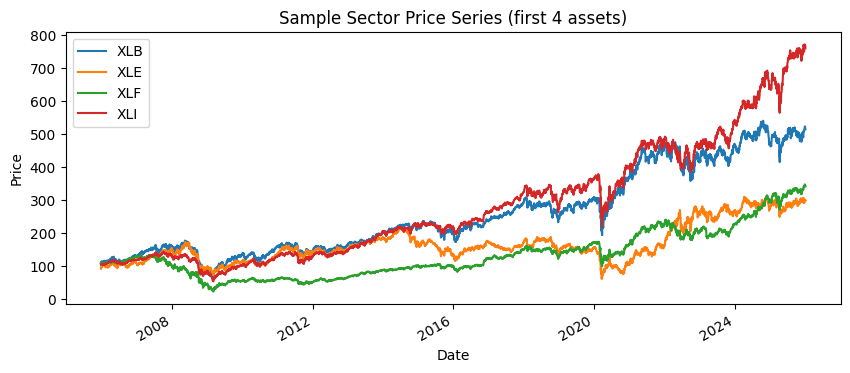

count      mean      std       min       25%       50%  \
vix_z   5,035.000000  0.043945 1.042697 -1.405608 -0.640535 -0.285798   
dxy_z   5,035.000000  0.596332 1.296871 -3.469024 -0.258165  0.792225   
spred_z 5,035.000000 -0.227947 1.214108 -3.096591 -1.015182 -0.244951   

             75%      max  
vix_z   0.360690 7.413477  
dxy_z   1.542752 4.021587  
spred_z 0.492978 4.425140

In [54]:
# データの確認
ax = dataset["asset_prices"].iloc[:, :4].plot(figsize=(10, 4), title="Sample Sector Price Series (first 4 assets)")
ax.set_ylabel("Price")
plt.show()

display(dataset["features"].describe().T)


## 2. RL環境（Market Replay + DSR報酬）

- 行動: `n_assets + cash` 次元の連続値を softmax して重み化
- 約定: 時点 `t` 価格で整数株化（切り下げ）し、残余は現金
- 報酬: Differential Sharpe Ratio
- 観測: `[(n+1) x lookback]`


In [55]:
def stable_softmax(x: np.ndarray) -> np.ndarray:
    z = x - np.max(x)
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z)


class DifferentialSharpeTracker:
    def __init__(self, eta: float, eps: float = 1e-8):
        self.eta = eta
        self.eps = eps
        self.A = 0.0
        self.B = 0.0

    def update(self, realized_return: float) -> float:
        delta_A = realized_return - self.A
        delta_B = realized_return ** 2 - self.B

        denom = max(self.B - self.A ** 2, self.eps)
        dsr = (self.B * delta_A - 0.5 * self.A * delta_B) / (denom ** 1.5)

        self.A = self.A + self.eta * delta_A
        self.B = self.B + self.eta * delta_B
        return float(np.clip(dsr, -10.0, 10.0))


class PortfolioReplayEnv(gym.Env):
    metadata = {"render_modes": []}

    def __init__(
        self,
        prices: pd.DataFrame,
        log_returns: pd.DataFrame,
        features: pd.DataFrame,
        lookback: int,
        initial_cash: float,
        eta: float,
        random_reset: bool = False,
        seed: int = 42,
    ):
        super().__init__()
        self.prices = prices.copy()
        self.log_returns = log_returns.copy()
        self.features = features.copy()

        self.lookback = lookback
        self.initial_cash = float(initial_cash)
        self.random_reset = random_reset
        self.rng = np.random.default_rng(seed)

        self.n_assets = self.prices.shape[1]
        self.n_actions = self.n_assets + 1  # + cash

        self.action_space = spaces.Box(
            low=-10.0,
            high=10.0,
            shape=(self.n_actions,),
            dtype=np.float32,
        )
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(self.n_actions, self.lookback),
            dtype=np.float32,
        )

        self.dsr = DifferentialSharpeTracker(eta=eta)
        self._reset_state()

    def _reset_state(self):
        self.shares = np.zeros(self.n_assets, dtype=np.int64)
        self.cash = self.initial_cash
        self.current_step = self.lookback
        self.history_values: List[float] = []
        self.history_returns: List[float] = []
        self.history_weights: List[np.ndarray] = []

    def _portfolio_value(self, step_idx: int) -> float:
        prices_t = self.prices.iloc[step_idx].to_numpy(dtype=np.float64)
        return float(np.dot(self.shares, prices_t) + self.cash)

    def _current_weights(self, step_idx: int) -> np.ndarray:
        prices_t = self.prices.iloc[step_idx].to_numpy(dtype=np.float64)
        port_val = max(self._portfolio_value(step_idx), 1e-12)
        asset_values = self.shares * prices_t
        cash_value = np.array([self.cash], dtype=np.float64)
        w = np.concatenate([asset_values, cash_value]) / port_val
        return w

    def _get_observation(self) -> np.ndarray:
        obs = np.zeros((self.n_actions, self.lookback), dtype=np.float32)

        w_t = self._current_weights(self.current_step)
        obs[:, 0] = w_t.astype(np.float32)

        lr_window = self.log_returns.iloc[self.current_step - self.lookback : self.current_step]
        obs[: self.n_assets, :] = lr_window.to_numpy(dtype=np.float32).T

        f = self.features.iloc[self.current_step]
        obs[self.n_assets, 0] = float(f["vix_z"])
        obs[self.n_assets, 1] = float(f["dxy_z"])
        obs[self.n_assets, 2] = float(f["spred_z"])

        return obs

    def _rebalance_with_integer_shares(self, target_weights: np.ndarray, step_idx: int):
        prices_t = self.prices.iloc[step_idx].to_numpy(dtype=np.float64)
        portfolio_value = self._portfolio_value(step_idx)

        target_values = target_weights * portfolio_value
        target_asset_values = target_values[: self.n_assets]

        target_shares = np.floor(np.divide(target_asset_values, prices_t, out=np.zeros_like(target_asset_values), where=prices_t > 0)).astype(np.int64)
        invested = float(np.dot(target_shares, prices_t))

        self.shares = target_shares
        self.cash = float(max(portfolio_value - invested, 0.0))

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._reset_state()
        self.dsr = DifferentialSharpeTracker(eta=self.dsr.eta)

        if self.random_reset:
            max_start = len(self.prices) - 2
            self.current_step = int(self.rng.integers(self.lookback, max_start + 1))

        obs = self._get_observation()
        info = {"portfolio_value": self._portfolio_value(self.current_step)}
        return obs, info

    def step(self, action):
        if self.current_step >= len(self.prices) - 1:
            return self._get_observation(), 0.0, True, False, {"portfolio_value": self._portfolio_value(self.current_step)}

        w_target = stable_softmax(np.asarray(action, dtype=np.float64))

        # t時点でリバランス
        portfolio_value_t = self._portfolio_value(self.current_step)
        self._rebalance_with_integer_shares(w_target, self.current_step)

        # t+1へ進み、実現リターンを計算
        self.current_step += 1
        portfolio_value_t1 = self._portfolio_value(self.current_step)

        realized_return = (portfolio_value_t1 / max(portfolio_value_t, 1e-12)) - 1.0
        reward = self.dsr.update(realized_return)

        done = self.current_step >= len(self.prices) - 1
        truncated = False

        self.history_values.append(portfolio_value_t1)
        self.history_returns.append(realized_return)
        self.history_weights.append(self._current_weights(self.current_step))

        obs = self._get_observation()
        info = {
            "portfolio_value": portfolio_value_t1,
            "realized_return": realized_return,
            "weights": self.history_weights[-1],
        }
        return obs, reward, done, truncated, info


## 3. 学習・検証・バックテストの関数群

- 10個のスライディング窓（5年train / 1年burn / 1年test）
- 各窓で5seed学習し、burn yearで最良モデルを採択
- 次窓では最良モデルをwarm-start初期値として再学習


In [56]:
def linear_schedule(start: float, end: float) -> Callable[[float], float]:
    def _fn(progress_remaining: float) -> float:
        return end + (start - end) * progress_remaining
    return _fn


def make_env_fn(
    prices: pd.DataFrame,
    log_returns: pd.DataFrame,
    features: pd.DataFrame,
    config: ExperimentConfig,
    random_reset: bool,
    seed: int,
) -> Callable[[], PortfolioReplayEnv]:
    def _init() -> PortfolioReplayEnv:
        return PortfolioReplayEnv(
            prices=prices,
            log_returns=log_returns,
            features=features,
            lookback=config.lookback,
            initial_cash=config.initial_cash,
            eta=config.eta,
            random_reset=random_reset,
            seed=seed,
        )
    return _init


def build_sliding_windows() -> List[Dict[str, int]]:
    windows = []
    for i in range(10):
        train_start = 2006 + i
        train_end = train_start + 5
        val_year = train_end
        test_year = val_year + 1
        windows.append(
            {
                "id": i,
                "train_start": train_start,
                "train_end_exclusive": train_end,
                "val_year": val_year,
                "test_year": test_year,
            }
        )
    return windows


def slice_by_year(df: pd.DataFrame, year_start: int, year_end_exclusive: int) -> pd.DataFrame:
    return df[(df.index.year >= year_start) & (df.index.year < year_end_exclusive)]


def train_ppo_for_seed(
    prices: pd.DataFrame,
    log_returns: pd.DataFrame,
    features: pd.DataFrame,
    config: ExperimentConfig,
    seed: int,
    warm_start_path: Optional[Path] = None,
) -> PPO:
    env_fns = [
        make_env_fn(prices, log_returns, features, config, random_reset=True, seed=seed + i)
        for i in range(config.n_envs)
    ]

    vec_env = SubprocVecEnv(env_fns) if config.n_envs > 1 else DummyVecEnv([env_fns[0]])

    policy_kwargs = dict(
        net_arch=list(config.policy_hidden_sizes),
        activation_fn=torch.nn.Tanh,
        log_std_init=config.log_std_init,
    )

    if warm_start_path is not None and warm_start_path.exists():
        model = PPO.load(
            str(warm_start_path),
            env=vec_env,
            device=config.device,
            seed=seed,
            print_system_info=False,
        )
    else:
        model = PPO(
            "MlpPolicy",
            vec_env,
            learning_rate=linear_schedule(config.learning_rate_start, config.learning_rate_end),
            n_steps=config.n_steps,
            batch_size=config.batch_size,
            n_epochs=config.n_epochs,
            gamma=config.gamma,
            gae_lambda=config.gae_lambda,
            clip_range=config.clip_range,
            policy_kwargs=policy_kwargs,
            seed=seed,
            device=config.device,
            verbose=0,
        )

    model.learn(total_timesteps=config.total_timesteps, progress_bar=config.use_progress_bar)
    vec_env.close()
    return model


def evaluate_model_on_validation(
    model: PPO,
    prices: pd.DataFrame,
    log_returns: pd.DataFrame,
    features: pd.DataFrame,
    config: ExperimentConfig,
) -> float:
    eval_env = DummyVecEnv([
        make_env_fn(prices, log_returns, features, config, random_reset=False, seed=777)
    ])
    mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=1, deterministic=True)
    eval_env.close()
    return float(mean_reward)


def run_drl_backtest(
    model: PPO,
    prices: pd.DataFrame,
    log_returns: pd.DataFrame,
    features: pd.DataFrame,
    config: ExperimentConfig,
) -> Dict[str, pd.DataFrame]:
    env = PortfolioReplayEnv(
        prices=prices,
        log_returns=log_returns,
        features=features,
        lookback=config.lookback,
        initial_cash=config.initial_cash,
        eta=config.eta,
        random_reset=False,
        seed=999,
    )

    obs, info = env.reset()
    done = False
    perf_rows = []
    weight_rows = []
    weight_cols = [f"w_{c}" for c in prices.columns] + ["w_cash"]

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        dt = env.prices.index[env.current_step]
        perf_rows.append(
            {
                "date": dt,
                "portfolio_value": info["portfolio_value"],
                "realized_return": info["realized_return"],
                "reward_dsr": reward,
                "strategy": "DRL",
            }
        )

        w_arr = np.asarray(info.get("weights"), dtype=np.float64)
        if w_arr.shape[0] != len(weight_cols):
            w_arr = env._current_weights(env.current_step)

        w_row = {"date": dt, "strategy": "DRL"}
        for col, val in zip(weight_cols, w_arr):
            w_row[col] = float(val)
        weight_rows.append(w_row)

    perf = pd.DataFrame(perf_rows).set_index("date")
    weights = pd.DataFrame(weight_rows).set_index("date")
    return {"performance": perf, "weights": weights}


## 4. MVO / EQW ベースライン

- MVO: 60日ルックバックで平均・共分散推定、Ledoit-Wolf shrinkage、Sharpe最大化
- EQW: 非現金資産を日次で等ウェイト目標にリバランス
- 両戦略とも整数株執行 + 残余現金保持で DRL と条件を揃える


In [57]:
def project_to_psd(cov: np.ndarray, eps: float = 1e-10) -> np.ndarray:
    eigvals, eigvecs = np.linalg.eigh(cov)
    eigvals = np.clip(eigvals, eps, None)
    cov_psd = eigvecs @ np.diag(eigvals) @ eigvecs.T
    cov_psd = (cov_psd + cov_psd.T) / 2.0
    return cov_psd


def solve_mvo_weights(lookback_simple_ret: pd.DataFrame) -> np.ndarray:
    mu = lookback_simple_ret.mean() * 252

    lw = LedoitWolf()
    lw.fit(lookback_simple_ret.values)
    cov = lw.covariance_ * 252
    cov = project_to_psd(cov)

    ef = EfficientFrontier(mu, cov, weight_bounds=(0.0, 1.0))
    _ = ef.max_sharpe(risk_free_rate=0.0)
    w_dict = ef.clean_weights()
    w = np.array([w_dict.get(c, 0.0) for c in lookback_simple_ret.columns], dtype=np.float64)

    total = w.sum()
    if total <= 0:
        w = np.ones_like(w) / len(w)
    else:
        w = w / total
    return w


def _run_target_weight_backtest(
    prices: pd.DataFrame,
    lookback: int,
    initial_cash: float,
    target_weight_fn: Callable[[int], np.ndarray],
    strategy: str,
) -> Dict[str, pd.DataFrame]:
    n_assets = prices.shape[1]
    shares = np.zeros(n_assets, dtype=np.int64)
    cash = float(initial_cash)

    perf_rows = []
    weight_rows = []
    weight_cols = [f"w_{c}" for c in prices.columns] + ["w_cash"]

    for t in range(lookback, len(prices) - 1):
        date_t1 = prices.index[t + 1]

        p_t = prices.iloc[t].to_numpy(dtype=np.float64)
        p_t1 = prices.iloc[t + 1].to_numpy(dtype=np.float64)

        port_val_t = float(np.dot(shares, p_t) + cash)

        w_assets = np.asarray(target_weight_fn(t), dtype=np.float64)
        if w_assets.shape[0] != n_assets:
            w_assets = np.ones(n_assets, dtype=np.float64) / n_assets

        w_assets = np.clip(w_assets, 0.0, None)
        total_w = float(w_assets.sum())
        if total_w <= 0:
            w_assets = np.ones(n_assets, dtype=np.float64) / n_assets
        else:
            w_assets = w_assets / total_w

        target_values = w_assets * port_val_t
        target_shares = np.floor(np.divide(target_values, p_t, out=np.zeros_like(target_values), where=p_t > 0)).astype(np.int64)

        invested = float(np.dot(target_shares, p_t))
        shares = target_shares
        cash = float(max(port_val_t - invested, 0.0))

        port_val_t1 = float(np.dot(shares, p_t1) + cash)
        realized_return = (port_val_t1 / max(port_val_t, 1e-12)) - 1.0

        perf_rows.append(
            {
                "date": date_t1,
                "portfolio_value": port_val_t1,
                "realized_return": realized_return,
                "strategy": strategy,
            }
        )

        asset_values_t1 = shares * p_t1
        total_t1 = max(port_val_t1, 1e-12)
        w_all = np.concatenate([asset_values_t1, np.array([cash])]) / total_t1

        w_row = {"date": date_t1, "strategy": strategy}
        for col, val in zip(weight_cols, w_all):
            w_row[col] = float(val)
        weight_rows.append(w_row)

    perf = pd.DataFrame(perf_rows).set_index("date")
    weights = pd.DataFrame(weight_rows).set_index("date")
    return {"performance": perf, "weights": weights}


def run_mvo_backtest(
    prices: pd.DataFrame,
    simple_returns: pd.DataFrame,
    lookback: int,
    initial_cash: float,
) -> Dict[str, pd.DataFrame]:
    def target_weight_fn(t: int) -> np.ndarray:
        lb = simple_returns.iloc[t - lookback : t]
        try:
            return solve_mvo_weights(lb)
        except Exception:
            return np.ones(prices.shape[1], dtype=np.float64) / prices.shape[1]

    return _run_target_weight_backtest(
        prices=prices,
        lookback=lookback,
        initial_cash=initial_cash,
        target_weight_fn=target_weight_fn,
        strategy="MVO",
    )


def run_eqw_backtest(
    prices: pd.DataFrame,
    lookback: int,
    initial_cash: float,
) -> Dict[str, pd.DataFrame]:
    n_assets = prices.shape[1]
    eqw = np.ones(n_assets, dtype=np.float64) / n_assets

    def target_weight_fn(t: int) -> np.ndarray:
        return eqw

    return _run_target_weight_backtest(
        prices=prices,
        lookback=lookback,
        initial_cash=initial_cash,
        target_weight_fn=target_weight_fn,
        strategy="EQW",
    )


## 5. 指標計算と可視化

- Equity curve（連結後）に加え、戦略別ウェイト時系列を可視化する。


In [58]:
def chain_portfolio_values(perf_df: pd.DataFrame, initial_cash: float) -> pd.DataFrame:
    required_cols = {"strategy", "window_id", "realized_return", "portfolio_value"}
    missing = required_cols - set(perf_df.columns)
    if missing:
        raise ValueError(f"perf_df missing required columns: {sorted(missing)}")

    if len(perf_df) == 0:
        return perf_df

    date_col = perf_df.index.name if perf_df.index.name else "date"
    df = perf_df.reset_index().rename(columns={date_col: "date"})

    chained_parts = []
    for strategy, g in df.groupby("strategy", sort=False):
        # 欠損realized_return行は連続化対象から除外
        g = g.dropna(subset=["date", "window_id", "realized_return"]).copy()
        if len(g) == 0:
            continue

        g["window_id"] = g["window_id"].astype(int)
        g = g.sort_values(["window_id", "date"]).copy()

        capital = float(initial_cash)
        per_window = []
        for window_id, wdf in g.groupby("window_id", sort=True):
            wdf = wdf.sort_values("date").copy()
            growth = (1.0 + wdf["realized_return"].astype(float)).cumprod()
            wdf["portfolio_value"] = capital * growth
            capital = float(wdf["portfolio_value"].iloc[-1])
            per_window.append(wdf)

        if per_window:
            chained_parts.append(pd.concat(per_window, axis=0))

    if not chained_parts:
        return perf_df

    chained = pd.concat(chained_parts, axis=0)
    chained = chained.set_index("date")
    chained.index.name = perf_df.index.name if perf_df.index.name else "date"

    # 元の列順を維持
    for c in perf_df.columns:
        if c not in chained.columns:
            chained[c] = np.nan
    chained = chained[list(perf_df.columns)]

    return chained.sort_index()


def compute_metrics(returns: pd.Series, portfolio_values: pd.Series) -> Dict[str, float]:
    r = returns.dropna()
    if len(r) == 0:
        return {}

    ann_factor = 252
    mean_daily = r.mean()
    std_daily = r.std(ddof=0)

    ann_return = (1.0 + mean_daily) ** ann_factor - 1.0
    ann_vol = std_daily * math.sqrt(ann_factor)
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

    running_max = portfolio_values.cummax()
    drawdown = (portfolio_values / running_max) - 1.0
    max_dd = float(drawdown.min())

    downside = r[r < 0]
    downside_std = downside.std(ddof=0) * math.sqrt(ann_factor) if len(downside) > 1 else np.nan
    sortino = ann_return / downside_std if downside_std and downside_std > 0 else np.nan

    var_5 = np.percentile(r, 5)

    return {
        "Annual return": float(ann_return),
        "Annual volatility": float(ann_vol),
        "Sharpe ratio": float(sharpe),
        "Sortino ratio": float(sortino) if not pd.isna(sortino) else np.nan,
        "Max drawdown": max_dd,
        "Daily value at risk (5%)": float(var_5),
    }


def summarize_performance(perf_df: pd.DataFrame) -> pd.DataFrame:
    records = []
    for strategy, g in perf_df.groupby("strategy"):
        m = compute_metrics(g["realized_return"], g["portfolio_value"])
        m["Strategy"] = strategy
        records.append(m)
    out = pd.DataFrame(records).set_index("Strategy")
    return out


def plot_equity_curves(perf_df: pd.DataFrame, title: str):
    fig, ax = plt.subplots(figsize=(10, 4))
    for strategy, g in perf_df.groupby("strategy"):
        ax.plot(g.index, g["portfolio_value"], label=strategy)
    ax.set_title(title)
    ax.set_ylabel("Portfolio Value")
    ax.legend()
    plt.show()


def plot_weight_timeseries(weights_df: pd.DataFrame, asset_symbols: List[str]):
    if len(weights_df) == 0:
        print("weights_df is empty")
        return

    plot_cols = [f"w_{s}" for s in asset_symbols if f"w_{s}" in weights_df.columns]
    if "w_cash" in weights_df.columns:
        plot_cols.append("w_cash")

    if len(plot_cols) == 0:
        print("No weight columns found for plotting")
        return

    strategies = sorted(weights_df["strategy"].dropna().unique().tolist())
    fig, axes = plt.subplots(
        nrows=len(strategies),
        ncols=1,
        figsize=(12, max(3, 3 * len(strategies))),
        sharex=True,
    )
    if len(strategies) == 1:
        axes = [axes]

    for ax, strategy in zip(axes, strategies):
        g = weights_df[weights_df["strategy"] == strategy].sort_index()
        for c in plot_cols:
            ax.plot(g.index, g[c], label=c, linewidth=0.9)
        ax.set_ylim(-0.05, 1.05)
        ax.set_ylabel(strategy)
        ax.grid(alpha=0.2)

    axes[0].set_title("Weight Time Series by Strategy")
    axes[-1].set_xlabel("Date")
    handles, labels = axes[0].get_legend_handles_labels()
    if len(handles) > 0:
        axes[0].legend(loc="upper right", ncol=min(5, len(labels)), fontsize=8)
    plt.tight_layout()
    plt.show()


## 6. 10スライディング窓 実験オーケストレーション

- `run_full_training=False` の場合は DRL 学習をスキップし、MVO/EQW を評価する。
- 実行時は `performance` と `weights` を返し、Notebookで可視化する。
- 既存の損益系CSV（performance/summary）の保存ロジックは維持する。


id  train_start  train_end_exclusive  val_year  test_year
0   0         2006                 2011      2011       2012
1   1         2007                 2012      2012       2013
2   2         2008                 2013      2013       2014
3   3         2009                 2014      2014       2015
4   4         2010                 2015      2015       2016
5   5         2011                 2016      2016       2017
6   6         2012                 2017      2017       2018
7   7         2013                 2018      2018       2019
8   8         2014                 2019      2019       2020
9   9         2015                 2020      2020       2021


[window 0] train=2006-2010, val=2011, test=2012
  training seed=11
    val_score=-3.140941
  training seed=22
    val_score=-1.290069
  training seed=33
    val_score=-2.367091
  training seed=44
    val_score=-1.909858
  training seed=55
    val_score=-2.672236

[window 1] train=2007-2011, val=2012, test=2013
  training seed=11
    val_score=-5.858947
  training seed=22
    val_score=-4.902894
  training seed=33
    val_score=-4.174871
  training seed=44
    val_score=-3.056996
  training seed=55
    val_score=-3.110679

[window 2] train=2008-2012, val=2013, test=2014
  training seed=11
    val_score=35.288306
  training seed=22
    val_score=33.319979
  training seed=33
    val_score=32.758544
  training seed=44
    val_score=33.359718
  training seed=55
    val_score=33.162950

[window 3] train=2009-2013, val=2014, test=2015
  training seed=11
    val_score=12.310775
  training seed=22
    val_score=12.109859
  training seed=33
    val_score=12.084418
  training seed=44
    val_sco

portfolio_value  realized_return  reward_dsr strategy  window_id
date                                                                        
2012-03-30   100,422.163955         0.004222    0.000000      DRL          0
2012-03-30    99,814.686844        -0.001853         NaN      MVO          0
2012-03-30   100,464.260555         0.004643         NaN      EQW          0
2012-04-02   101,090.489671         0.006655    5.299857      DRL          0
2012-04-02   100,744.133329         0.009312         NaN      MVO          0

Annual return  Annual volatility  Sharpe ratio  Sortino ratio  \
Strategy                                                                  
DRL            0.150382           0.124726      1.205699       1.586178   
EQW            0.168894           0.134742      1.253468       1.645237   
MVO            0.095806           0.140206      0.683327       0.893345   

          Max drawdown  Daily value at risk (5%)  
Strategy                                          
DRL          -0.179791                 -0.012865  
EQW          -0.182814                 -0.013890  
MVO          -0.184553                 -0.014577

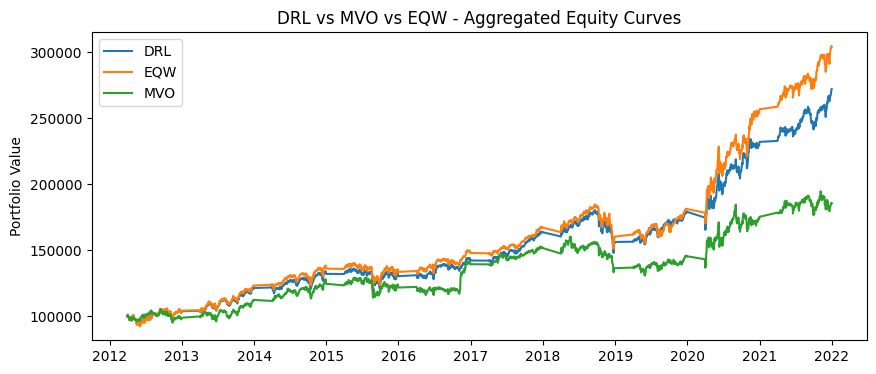

strategy    w_XLB    w_XLE    w_XLF    w_XLI    w_XLK    w_XLP  \
date                                                                        
2012-03-30      DRL 0.097641 0.093892 0.112097 0.093433 0.093703 0.106457   
2012-03-30      EQW 0.110193 0.111450 0.110812 0.110375 0.109274 0.109845   
2012-03-30      MVO 0.000000 0.000000 0.000000 0.000000 0.846889 0.000000   
2012-04-02      DRL 0.096773 0.092710 0.113442 0.091996 0.094071 0.108310   
2012-04-02      EQW 0.110915 0.110234 0.110827 0.110260 0.111182 0.109895   

              w_XLU    w_XLV    w_XLY   w_cash  window_id  
date                                                       
2012-03-30 0.092497 0.104887 0.098614 0.106779          0  
2012-03-30 0.110950 0.110219 0.110705 0.006176          0  
2012-03-30 0.000000 0.000000 0.151111 0.002000          0  
2012-04-02 0.092357 0.104554 0.098223 0.107565          0  
2012-04-02 0.110694 0.109781 0.110177 0.006037          0

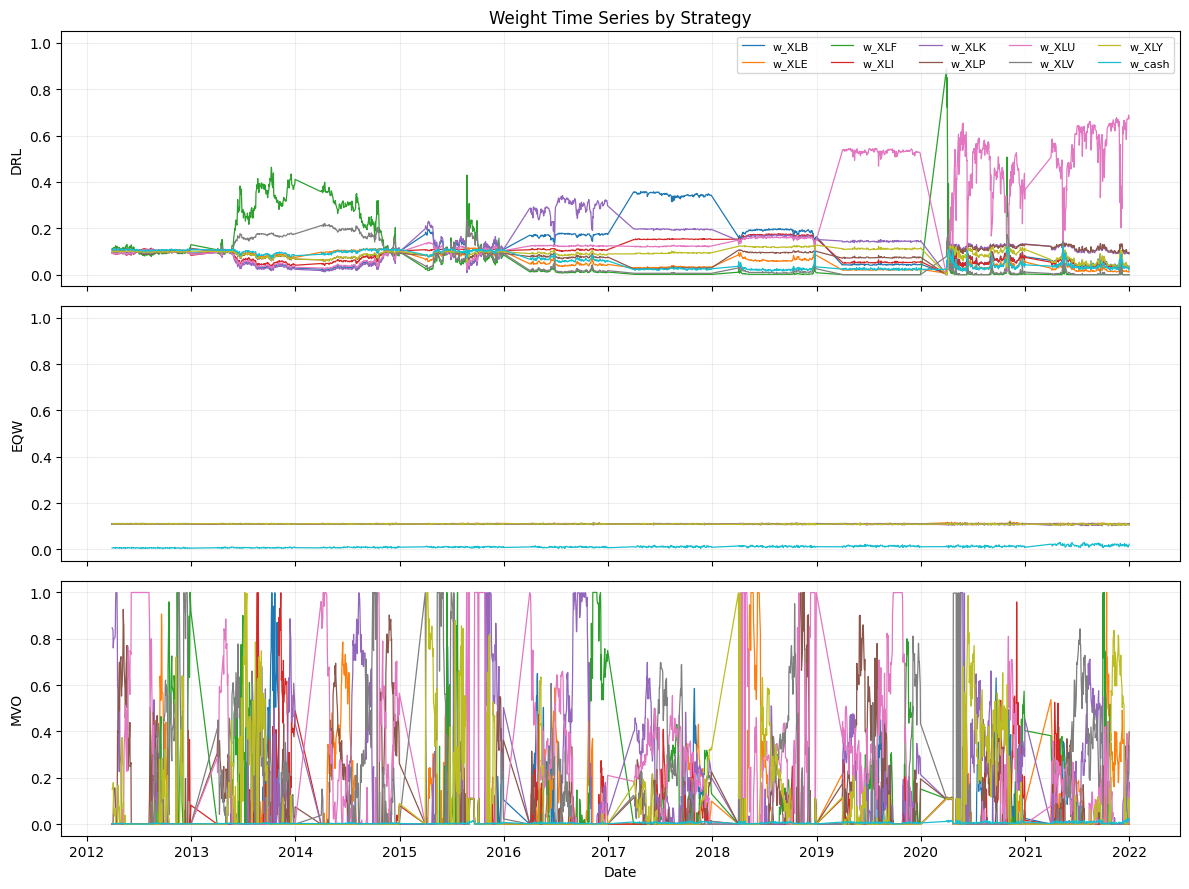

In [59]:
def run_experiment(config: ExperimentConfig, data: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]:
    prices_all = data["asset_prices"]
    logret_all = data["asset_logret"]
    simple_all = data["asset_simple_ret"]
    features_all = data["features"]

    windows = build_sliding_windows()
    display(pd.DataFrame(windows))

    all_perf_rows = []
    all_weight_rows = []
    best_model_path_prev: Optional[Path] = None

    for w in windows:
        train_s = w["train_start"]
        train_e = w["train_end_exclusive"]
        val_y = w["val_year"]
        test_y = w["test_year"]

        # lookback計算用にtrain開始年の前年10月から確保
        train_prices = prices_all[(prices_all.index.year >= train_s) & (prices_all.index.year < train_e)]
        train_logret = logret_all.loc[train_prices.index]
        train_feat = features_all.loc[train_prices.index]

        val_prices = slice_by_year(prices_all, val_y, val_y + 1)
        val_logret = logret_all.loc[val_prices.index]
        val_feat = features_all.loc[val_prices.index]

        test_prices = slice_by_year(prices_all, test_y, test_y + 1)
        test_logret = logret_all.loc[test_prices.index]
        test_feat = features_all.loc[test_prices.index]
        test_simple = simple_all.loc[test_prices.index]

        if len(train_prices) < config.lookback + 2 or len(val_prices) < config.lookback + 2 or len(test_prices) < config.lookback + 2:
            print(f"[skip] window {w['id']} insufficient rows")
            continue

        print(f"\n[window {w['id']}] train={train_s}-{train_e-1}, val={val_y}, test={test_y}")

        if config.run_full_training:
            best_model = None
            best_score = -np.inf

            for seed in config.seeds:
                print(f"  training seed={seed}")
                model = train_ppo_for_seed(
                    train_prices,
                    train_logret,
                    train_feat,
                    config,
                    seed=seed,
                    warm_start_path=best_model_path_prev,
                )
                val_score = evaluate_model_on_validation(model, val_prices, val_logret, val_feat, config)
                print(f"    val_score={val_score:.6f}")

                model_path = MODEL_DIR / f"ppo_window{w['id']}_seed{seed}.zip"
                model.save(str(model_path))

                if val_score > best_score:
                    best_score = val_score
                    best_model = model
                    best_model_path_prev = model_path

            drl_out = run_drl_backtest(best_model, test_prices, test_logret, test_feat, config)
        else:
            print("  run_full_training=False のため DRL学習はスキップ")
            drl_out = {"performance": pd.DataFrame(), "weights": pd.DataFrame()}

        mvo_out = run_mvo_backtest(
            prices=test_prices,
            simple_returns=test_simple,
            lookback=config.lookback,
            initial_cash=config.initial_cash,
        )

        eqw_out = run_eqw_backtest(
            prices=test_prices,
            lookback=config.lookback,
            initial_cash=config.initial_cash,
        )

        for out in [drl_out, mvo_out, eqw_out]:
            perf = out.get("performance", pd.DataFrame())
            weights = out.get("weights", pd.DataFrame())

            if len(perf) > 0:
                perf = perf.copy()
                perf["window_id"] = w["id"]
                all_perf_rows.append(perf)

            if len(weights) > 0:
                weights = weights.copy()
                weights["window_id"] = w["id"]
                all_weight_rows.append(weights)

    if len(all_perf_rows) == 0:
        return {"performance": pd.DataFrame(), "weights": pd.DataFrame()}

    perf_all = pd.concat(all_perf_rows).sort_index()
    perf_all = chain_portfolio_values(perf_all, config.initial_cash)

    if len(all_weight_rows) > 0:
        weights_all = pd.concat(all_weight_rows).sort_index()
    else:
        weights_all = pd.DataFrame()

    return {"performance": perf_all, "weights": weights_all}


result = run_experiment(cfg, dataset)
if len(result["performance"]) > 0:
    perf_df = result["performance"]
    display(perf_df.head())

    summary = summarize_performance(perf_df)
    display(summary)

    plot_equity_curves(perf_df, "DRL vs MVO vs EQW - Aggregated Equity Curves")

    weights_df = result.get("weights", pd.DataFrame())
    if len(weights_df) > 0:
        display(weights_df.head())
        asset_symbols = dataset["asset_symbols"]["symbol"].tolist()
        plot_weight_timeseries(weights_df, asset_symbols)
else:
    print("No performance rows generated. Turn on run_full_training or validate data availability.")


In [60]:
# 成果物保存（設定とデータ可用性サマリ）
manifest = {
    "config": asdict(cfg),
    "notebook": str(NOTEBOOK_PATH),
    "asset_symbols": dataset["asset_symbols"]["symbol"].tolist(),
    "asset_rows": int(len(dataset["asset_prices"])),
    "feature_rows": int(len(dataset["features"])),
    "run_full_training": cfg.run_full_training,
}

(OUTPUT_DIR / "phase_b_manifest.json").write_text(json.dumps(manifest, indent=2, ensure_ascii=False))

if "result" in globals() and isinstance(result, dict) and "performance" in result and len(result["performance"]) > 0:
    result["performance"].to_csv(ARTIFACT_DIR / "performance_timeseries.csv")
    summarize_performance(result["performance"]).to_csv(ARTIFACT_DIR / "summary_metrics.csv")

print("Saved:")
print("-", OUTPUT_DIR / "phase_b_manifest.json")
print("-", ARTIFACT_DIR / "performance_timeseries.csv (if generated)")
print("-", ARTIFACT_DIR / "summary_metrics.csv (if generated)")


Saved:
- /Users/kencharoff/workspace/projects/rl/p01_deep_reinforcement_learning_for_optimal_portfolio_allocation/outputs/phase_b/phase_b_manifest.json
- /Users/kencharoff/workspace/projects/rl/p01_deep_reinforcement_learning_for_optimal_portfolio_allocation/outputs/phase_b/artifacts/performance_timeseries.csv (if generated)
- /Users/kencharoff/workspace/projects/rl/p01_deep_reinforcement_learning_for_optimal_portfolio_allocation/outputs/phase_b/artifacts/summary_metrics.csv (if generated)


## 7. 実行メモ

- 本Notebookは `data/sector_returns.csv`, `data/macro.csv`, `data/SPX.csv` のローカルCSVで実行する（ネットワーク不要）。
- 論文と同条件で学習する場合は `cfg.run_full_training = True` に設定してから `run_experiment` を再実行。
- `total_timesteps=7_500_000`、`n_envs=10` は計算負荷が高い。検証目的では timesteps を縮小したスモーク実行を先に推奨。
- `cfg.use_progress_bar = False` が既定で、`rich/tqdm` が無くても学習実行できる。
- 再現監査時は `outputs/phase_b/phase_b_manifest.json` と生成CSVを証跡として利用する。
